# Load libraries and download files

In [ ]:
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# download files
# youtube toxic comments
## /content/preprocessed_normalized_dataset.csv
!gdown 1rd_c-YmsD8GbpREELVzSLL_SDkbNyipc
## /content/youtoxic_english_1000.csv
!gdown 13e5Kqw1xi1FXczVwgs8ajp-DgFORgPFe
# tweets  toxic comments
# from: https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset/data
## /content/FinalBalancedDataset.csv
!gdown 1B84nV8zAY1PxZ12w8Humi9aPq5UUIC5h

Downloading...
From: https://drive.google.com/uc?id=1rd_c-YmsD8GbpREELVzSLL_SDkbNyipc
To: /content/preprocessed_normalized_dataset.csv
100% 223k/223k [00:00<00:00, 3.42MB/s]
Downloading...
From: https://drive.google.com/uc?id=13e5Kqw1xi1FXczVwgs8ajp-DgFORgPFe
To: /content/youtoxic_english_1000.csv
100% 294k/294k [00:00<00:00, 3.80MB/s]
Downloading...
From: https://drive.google.com/uc?id=1B84nV8zAY1PxZ12w8Humi9aPq5UUIC5h
To: /content/FinalBalancedDataset.csv
100% 5.52M/5.52M [00:00<00:00, 31.6MB/s]


# Parameters

In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

In [ ]:
# load datasets
youtube_df = pd.read_csv('youtoxic_english_1000.csv')
youtube_df = youtube_df[['Text', 'IsToxic']]
youtube_df['IsToxic'] = youtube_df['IsToxic'].map({True:1,False:0})
tweets_df  = pd.read_csv('FinalBalancedDataset.csv')
tweets_df  = tweets_df[['tweet', 'Toxicity']]
tweets_df.columns = ['Text', 'IsToxic']
print("youtube dataframe columns:")
print(youtube_df.columns)
print()
print("tweets  dataframe columns:")
print(tweets_df.columns)

youtube dataframe columns:
Index(['Text', 'IsToxic'], dtype='object')

tweets  dataframe columns:
Index(['Text', 'IsToxic'], dtype='object')


In [ ]:
stemmer = SnowballStemmer("english")
stop_words = stopwords.words('english')
def data_cleaner(text):
    text = text.lower()
    text = text.replace(":("," sedih")
    text = text.replace(":)"," senang")
    text = text.replace(":3"," lucu")
    text = text.replace(":d"," senang")
    text = text.replace(":-)"," senang")
    text = text.replace("=)"," senang")
    text = re.sub(r'http\S+', ' ', text)      # remove urls
    text = re.sub(r'<.*?>',' ', text)         # remove html tags
    text = re.sub(r'\d+',' ', text)           # remove digits
    text = re.sub(r'#\w+',' ', text)          # remove hashtags
    text = re.sub(r'@\w+',' ', text)          # remove mentions
    text = re.sub(r'[^\w\s]',' ', text)       # remove punctuation
    text = re.sub('[^A-Za-z0-9 ]+', '', text) # remove characters that are not a letters or numbers
    text = " ".join([word for word in text.split() if not word in stop_words])   # remove stop words
    text = stemmer.stem(text)
    text = text.strip()
    return text

In [ ]:
youtube_df['Text'] = youtube_df['Text'].apply(data_cleaner)
tweets_df['Text']  = tweets_df['Text'].apply(data_cleaner)
df = pd.concat([youtube_df, tweets_df])

# Data visualzation

## Wordcloud

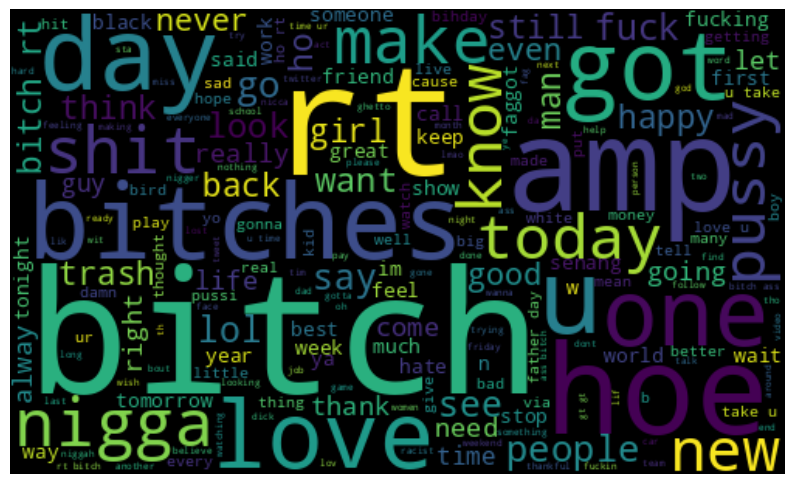

In [ ]:
# all texts
allWords = ' '.join([_ for _ in df['Text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

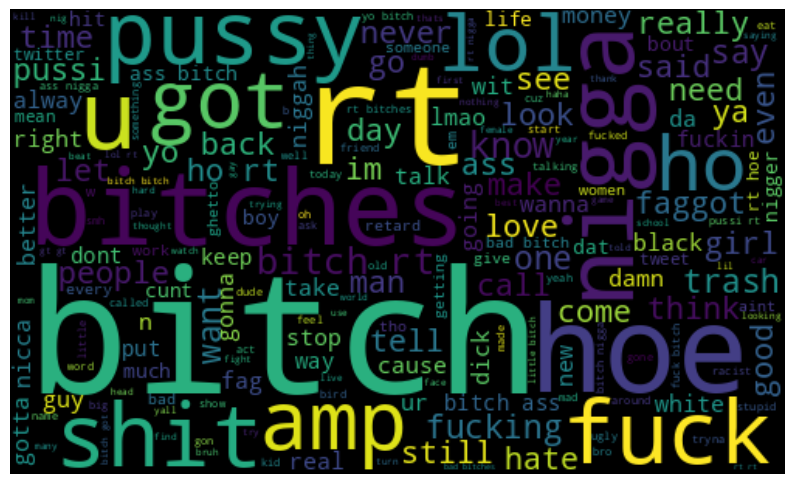

In [ ]:
# toxic texts
allWords = ' '.join([_ for _ in df[df['IsToxic'] == 1]['Text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

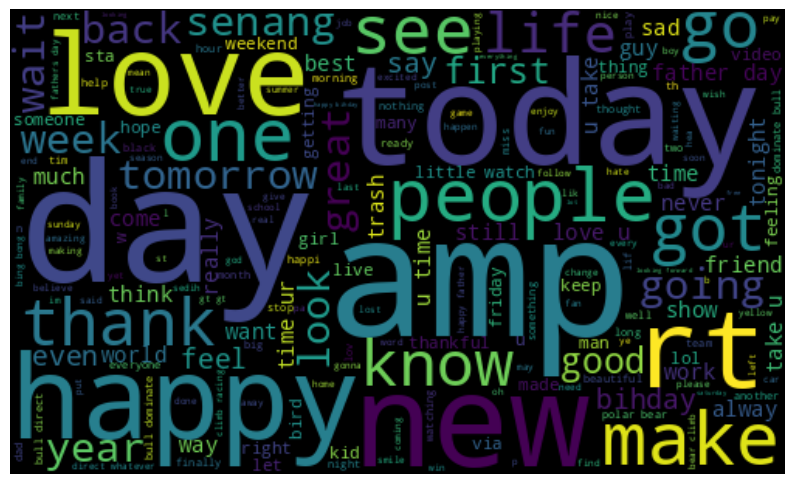

In [ ]:
# not toxic texts
allWords = ' '.join([_ for _ in df[df['IsToxic'] == 0]['Text']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)
plt.figure(figsize = (10, 8))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Distribution of Class

<Axes: xlabel='IsToxic', ylabel='count'>

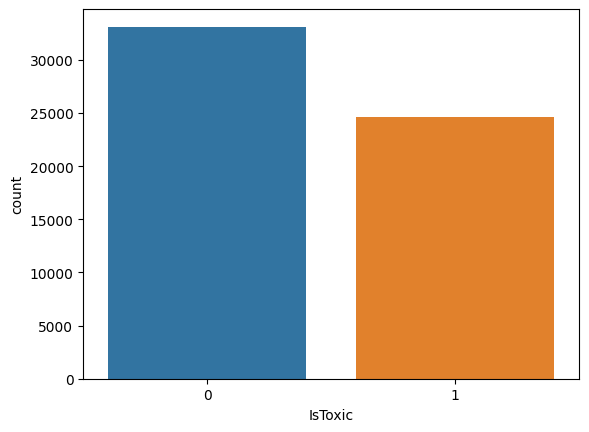

In [ ]:
sns.countplot(x = "IsToxic", data = df)

## Bar graph of youtube dataset

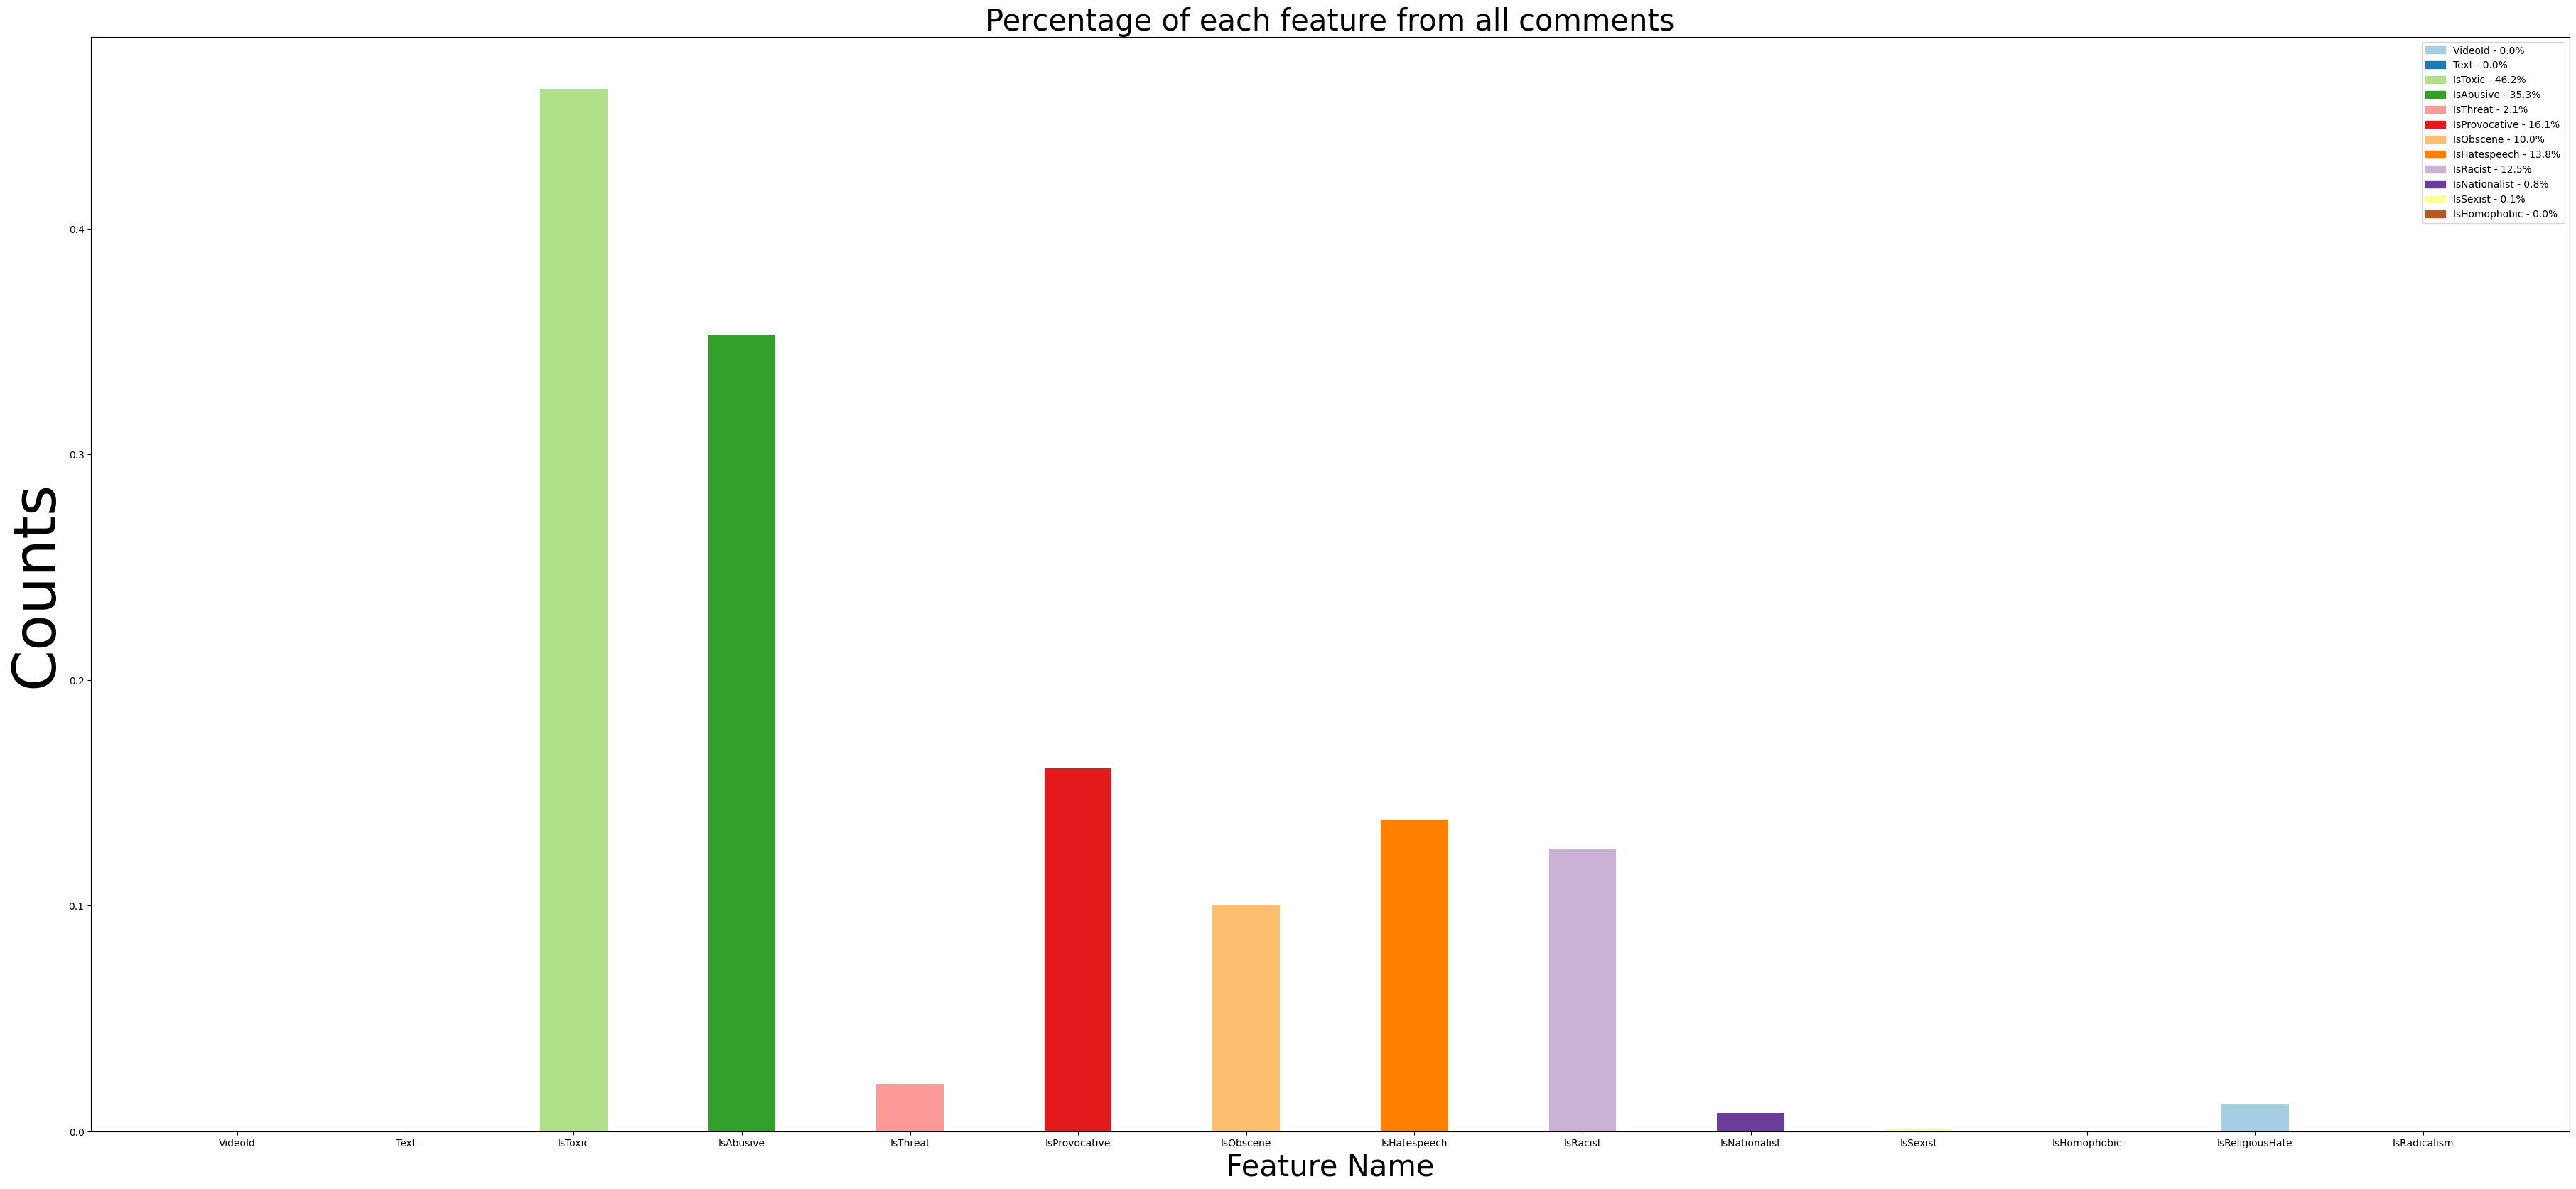

In [ ]:
comments_data = pd.read_csv('youtoxic_english_1000.csv')
columns_names = comments_data.columns.tolist()
bar_data = {}
for name in columns_names[1:]:
    bar_data[name] = len(comments_data.loc[comments_data[name] == 1])\
    /len(comments_data[name])

bar_name = list(bar_data.keys())
values = list(bar_data.values())
fig = plt.figure(figsize = (45, 20))
colors = plt.cm.Paired(np.arange(12))

plt.bar(bar_name, values, color = colors,
        width = 0.4)
plt.xlabel("Feature Name", fontsize=30)
plt.ylabel("Counts", fontsize=60) #~(~‾▿‾)~
plt.title("Percentage of each feature from all comments", fontsize=30)
patch = [mpatches.Patch(color=color, label=f"{bar_name} - {value*100}%")
         for color,value, bar_name in zip(colors, values, bar_name)]
plt.legend(handles=patch)
plt.show()

## Make cirvular infographic

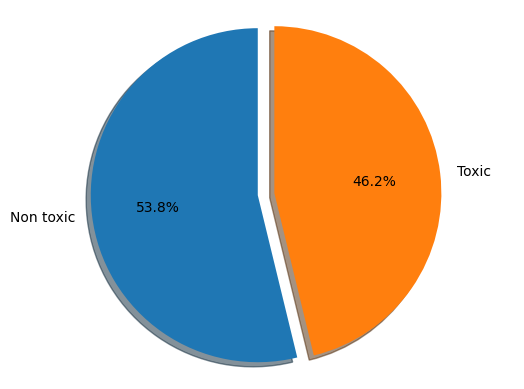

In [ ]:
# split all text by toxic parameter
non_toxic_mark = comments_data.IsToxic.loc[comments_data.IsToxic==0]
toxic_mark = comments_data.IsToxic.loc[comments_data.IsToxic==1]
labels = "Non toxic", "Toxic"
sizes = [non_toxic_mark.count(),
         toxic_mark.count()]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%",
        shadow=True, startangle=90)
ax1.axis("equal")
plt.show()

# Dataset

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = [str(t) for t in texts]
        self.labels = [int(i) for i in labels]
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [ ]:
#split data
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'].tolist(), df['IsToxic'].tolist(), test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Model

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Training (skip if load trained model, just run tesing)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = BERTClassifier(bert_model_name, num_classes).to(device)

cuda


In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)
torch.save(model.state_dict(), "/content/drive/MyDrive/bert_classifier.pth")

Epoch 1/4


100%|██████████| 722/722 [01:28<00:00,  8.20it/s]


Validation Accuracy: 0.9344
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6592
           1       0.94      0.91      0.92      4957

    accuracy                           0.93     11549
   macro avg       0.93      0.93      0.93     11549
weighted avg       0.93      0.93      0.93     11549

Epoch 2/4


100%|██████████| 722/722 [01:27<00:00,  8.21it/s]


Validation Accuracy: 0.9407
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      6592
           1       0.93      0.93      0.93      4957

    accuracy                           0.94     11549
   macro avg       0.94      0.94      0.94     11549
weighted avg       0.94      0.94      0.94     11549

Epoch 3/4


100%|██████████| 722/722 [01:28<00:00,  8.20it/s]


Validation Accuracy: 0.9399
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      6592
           1       0.94      0.92      0.93      4957

    accuracy                           0.94     11549
   macro avg       0.94      0.94      0.94     11549
weighted avg       0.94      0.94      0.94     11549

Epoch 4/4


100%|██████████| 722/722 [01:28<00:00,  8.20it/s]


Validation Accuracy: 0.9383
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      6592
           1       0.93      0.92      0.93      4957

    accuracy                           0.94     11549
   macro avg       0.94      0.94      0.94     11549
weighted avg       0.94      0.94      0.94     11549



# Testing

In [ ]:
# load fine-tuned bert model
# https://drive.google.com/file/d/1ACcWSUbfFmGFKxwJrw8aONF0atbWNJq4/view?usp=sharing
!gdown 1ACcWSUbfFmGFKxwJrw8aONF0atbWNJq4
model.load_state_dict(torch.load('/content/bert_classifier.pth'))

Downloading...
From: https://drive.google.com/uc?id=1ACcWSUbfFmGFKxwJrw8aONF0atbWNJq4
To: /content/bert_classifier.pth
100% 438M/438M [00:03<00:00, 143MB/s]


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F
def predict_language(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    if preds == 0:
        return 'Not Toxic', F.softmax(outputs[0], dim=0)[0].item()
    else:
        return 'Toxic', F.softmax(outputs[0], dim=0)[1].item()

In [ ]:
# Test sentiment prediction
i = 2
test_text = df['Text'].iloc[i]
language = predict_language(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted language: {language}")
if df['IsToxic'].iloc[i] == 0:
  print('True label: Not Toxic')
else:
  print('True label: Toxic')

dont reckon black lives matter banners held white cunts kinda patronizing ironically racist could come somethin better white folks give selves pride ooo look im nice black people always race actually whole world pussyfootin around fear racist fuckin daft man
Predicted language: ('Toxic', 0.9988105297088623)
True label: Toxic
